In [102]:
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torchvision import transforms as T,datasets,models
import torch
import os
from typing import Tuple
# opencv for image processing
import cv2
import tqdm

from sklearn.model_selection import train_test_split
import pytorch_lightning as pl


In [75]:
# Loading the immages from train and test
train_images= np.load('train_images.npy')
train_labels = np.load('train_labels.npy')
val_images= np.load('val_images.npy')
val_labels = np.load('val_labels.npy')

In [76]:
# Merge images
merged_images = np.concatenate((train_images, val_images), axis=0)
# Merge labels
merged_labels = np.concatenate((train_labels, val_labels), axis=0)

# Split the merged dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    merged_images, merged_labels, test_size=0.15, random_state=42, stratify=merged_labels
)
# Add the channel dimension to the images, that is 1 because we have grays scale images
train_images = np.expand_dims(train_images, axis=-1)
val_images = np.expand_dims(val_images, axis=-1)


1


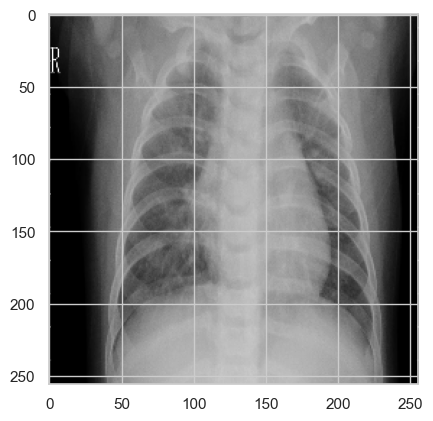

In [10]:
# Get all the pixel values in the range of 0 to 1
# train_images = train_images / 255.0
# display the image
# Crop the immage in 64x64

plt.imshow(train_images[2],
            cmap='gray')
print(train_labels[2])

In [45]:
# write the directory of where the data are installed
data_dir = "C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/data/chest_xray"

# The directory where the data are installed
print(os.listdir(data_dir))
print(os.listdir(data_dir + "/train"))


['.DS_Store', 'test', 'train', 'val']
['.DS_Store', 'NORMAL', 'PNEUMONIA']


In [96]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F 
from torch import nn,optim
from torchvision import transforms as T,datasets,models
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import torchmetrics
from collections import OrderedDict
from tqdm import tqdm
pd.options.plotting.backend = "plotly"
from torch import nn, optim
from torch.autograd import Variable
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

In [63]:
def data_transforms(phase = None):
    
    if phase == TRAIN:

        data_T = T.Compose([
                T.Resize(size = (256,256)),
                T.RandomRotation(degrees = (-20,+20)),
                T.CenterCrop(size=224),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    
    elif phase == TEST or phase == VAL:

        data_T = T.Compose([

                T.Resize(size = (224,224)),
                T.ToTensor(),
                T.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
        ])
    return data_T

In [64]:
data_dir = "C:/Users/gianf/Desktop/ETH/II_Semestre/ML4HC/ML4Healthcare/project1/task2/data/chest_xray"
TEST = 'test'
TRAIN = 'train'
VAL ='val'

trainset = datasets.ImageFolder(os.path.join(data_dir, TRAIN),transform = data_transforms(TRAIN))
testset = datasets.ImageFolder(os.path.join(data_dir, TEST),transform = data_transforms(TEST))
validset = datasets.ImageFolder(os.path.join(data_dir, VAL),transform = data_transforms(VAL))


In [65]:
class_names = trainset.classes
print(class_names)
print(trainset.class_to_idx)

['NORMAL', 'PNEUMONIA']
{'NORMAL': 0, 'PNEUMONIA': 1}


In [77]:
train_loader = DataLoader(trainset,batch_size = 64,shuffle = True)
valid_loader = DataLoader(validset,batch_size = 64,shuffle = True)
test_loader = DataLoader(testset,batch_size = 64,shuffle = True)

# Convert DataLoader to iterator
train_iter = iter(train_loader)
valid_iter = iter(valid_loader)
test_iter = iter(test_loader)

# Use next() on the iterator
images, labels = next(train_iter)
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 224, 224])
torch.Size([64])


In [78]:
print(f"There are {len(trainset)} train images and {len(validset)} val images")

There are 5216 train images and 16 val images


We have an inbalanced dataset, we will use the weights of the classes to balance the dataset

In [89]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



In [90]:
model = PneumoniaModel()  # Instanciate the model

In [93]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')


In [101]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

#gpus = 1 #TODO
#trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
#                     callbacks=checkpoint_callback,
#                     max_epochs=35)

TypeError: Trainer.__init__() got an unexpected keyword argument 'gpus'

In [100]:
pip list

Package                       Version
----------------------------- ---------------
absl-py                       2.1.0
aiobotocore                   2.5.0
aiofiles                      22.1.0
aiohttp                       3.8.5
aioitertools                  0.7.1
aiosignal                     1.2.0
aiosqlite                     0.18.0
alabaster                     0.7.12
anaconda-anon-usage           0.4.2
anaconda-catalogs             0.2.0
anaconda-client               1.12.1
anaconda-cloud-auth           0.1.3
anaconda-navigator            2.5.2
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.3
astroid                       2.14.2
astropy                       5.1
asttokens                     2.0.5
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs     